# Striplog with a binary 'flag'

We will invent a binary log -- maybe you can load it from an LAS file with `welly`.

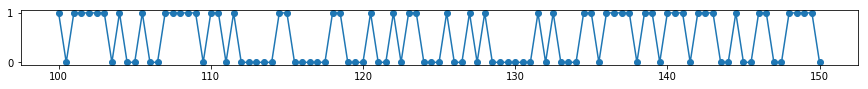

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

fake_depth = np.linspace(100, 150, 101)
fake_log = np.array([np.random.choice([0, 1]) for _ in fake_depth])

plt.figure(figsize=(15, 1))
plt.plot(fake_depth, fake_log, 'o-')

## Make a striplog

A `Striplog` is a sequence of `Interval` objects (representing a layer). Each `Interval` must contain a `Component` (representing the layer, perhaps a rock).

In [2]:
from striplog import Striplog, Component

In [3]:
comps = [
    Component({'pay': True}),
    Component({'pay': False})
]

In [4]:
s = Striplog.from_log(fake_log, cutoff=0.5, components=comps, basis=fake_depth)

In [5]:
s[-1].base.middle = 150.5 # Adjust the bottom thickness... not sure if this is a bug.

Each `Interval` in the striplog looks like:

In [6]:
s[0]

Interval({'top': Position({'middle': 100.0, 'units': 'm'}), 'base': Position({'middle': 100.5, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'pay': False})]})

## Plot the intervals

To plot we need a legend, but we can generate a random one. This maps each `Component` to a colour (and a width and hatch, if you want).

We can generate a random legend:

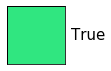

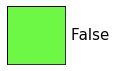

In [7]:
from striplog import Legend

legend = Legend.random(comps)
legend.get_decor(comps[-1]).width = 0.2
legend.plot()

Or we can make one with a bit more control:

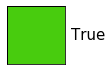

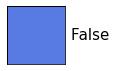

In [8]:

legend_csv = """colour,hatch,width,component pay
#48cc0e,None,1,True
#5779e2,None,0.2,False"""

legend = Legend.from_csv(text=legend_csv)

legend.plot()

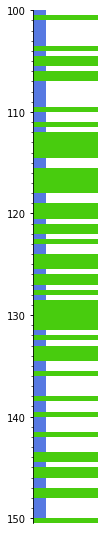

In [9]:
s.plot(legend=legend, aspect=5)

## Remove thin things

We can remove thin intervals:

In [10]:
pruned = s.prune(limit=1.0, keep_ends=True)

Now we can anneal the gaps:

In [11]:
annealed = pruned.anneal()

Then merge the adjacent intervals that are alike...

In [12]:
merged = annealed.merge_neighbours()  # Anneal works on a copy

We could have chained these commands:

    merged = s.prune(limit=1.0, keep_ends=True).anneal().merge_neighbours()

Let's plot all these steps, just for illustration:

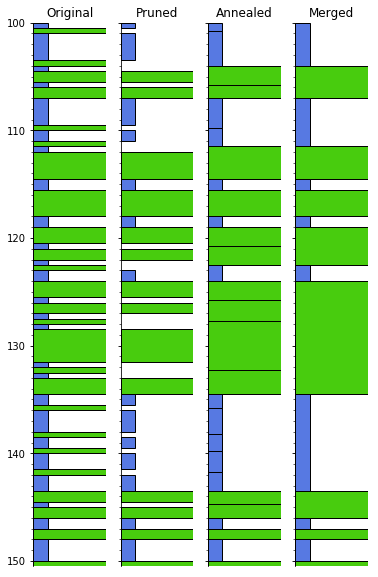

In [13]:
fig, axs = plt.subplots(ncols=4, figsize=(6, 10))

axs[0] = s.plot(legend=legend, ax=axs[0], lw=1, aspect=5)
axs[0].set_title('Original')
axs[1] = pruned.plot(legend=legend, ax=axs[1], lw=1, aspect=5)
axs[1].set_yticklabels([])
axs[1].set_title('Pruned')
axs[2] = annealed.plot(legend=legend, ax=axs[2], lw=1, aspect=5)
axs[2].set_yticklabels([])
axs[2].set_title('Annealed')
axs[3] = merged.plot(legend=legend, ax=axs[3], lw=1, aspect=5)
axs[3].set_yticklabels([])
axs[3].set_title('Merged')
plt.show()

## Dilate and erode

This would be a binary thing, at least for now. I made an issue for this: https://github.com/agile-geoscience/striplog/issues/95

You need to be on striplog v 0.8.1 at least for this to work.

In [14]:
from scipy.ndimage import morphology as bm

# Assumption:
# If the first (Python 3.6, 3.7) component item has a boolean value
# Then it's a 'binary striplog'. 
#
# Question: 
# Would it be better to subclass Striplog and make BinaryStriplog?
# Which could only have one field in the primary component.

def is_binary(strip, attr):
    """Determine if this striplog is interpretable as a binary striplog.
    """
    primaries = [getattr(i.primary, attr) for i in strip]
    return all(map(lambda x: isinstance(x, bool), primaries))

def binary_log(strip, attr, step):
    log, basis, comps = s.to_log(step=step, match_only=[attr], undefined=-1, return_meta=True)
    if -1 in log:
        print("We have undefined values, there might be a problem.")
    return log - 1, basis, comps

def binary_operation(strip, attr, operation, step=1, structure=None):
    ops = {
        'erosion': bm.binary_erosion,
        'dilation': bm.binary_dilation,
        'opening': bm.binary_opening,
        'closing': bm.binary_closing,
    }
    if not is_binary(strip, attr):
        print("Cannot interpret striplog as binary.")
    log, basis, comps = binary_log(strip, attr, step=step)
    if structure is None:
        raise TypeError("Structure cannot be None")
    try:   # Treat as int
        element = np.ones(int(structure))
    except:
        element = structure

    proc = ops[operation](log, structure=element)
    if operation == 'closing':
        proc = proc | log
    s = Striplog.from_log(proc, components=comps, basis=basis)
    return s

In [15]:
def net_to_gross(strip, attr):
    net = non = 0
    for c, x in strip.unique:
        if getattr(c, attr):
            net = x
        else:
            non = x
    return net / (net + non)

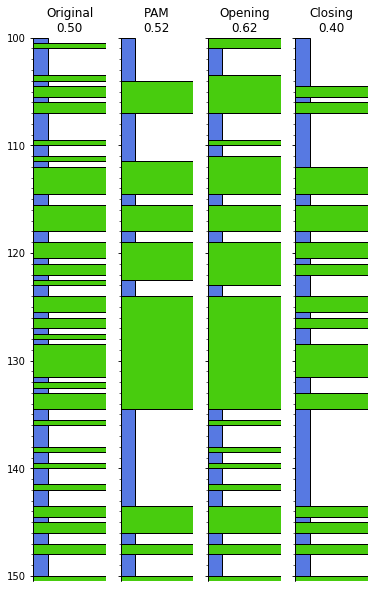

In [16]:
fig, axs = plt.subplots(ncols=4, figsize=(6, 10))

opening = binary_operation(s, 'pay', 'opening', step=0.1, structure=7)
closing = binary_operation(s, 'pay', 'closing', step=0.1, structure=7)

axs[0] = s.plot(legend=legend, ax=axs[0], lw=1, aspect=5)
ntg = net_to_gross(s, 'pay')
axs[0].set_title(f'Original\n{ntg:.2f}')
axs[1] = merged.plot(legend=legend, ax=axs[1], lw=1, aspect=5)
axs[1].set_yticklabels([])
ntg = net_to_gross(merged, 'pay')
axs[1].set_title(f'PAM\n{ntg:.2f}')  # Prune-anneal-merge
axs[2] = opening.plot(legend=legend, ax=axs[2], lw=1, aspect=5)
axs[2].set_yticklabels([])
ntg = net_to_gross(opening, 'pay')
axs[2].set_title(f'Opening\n{ntg:.2f}')
axs[3] = closing.plot(legend=legend, ax=axs[3], lw=1, aspect=5)
axs[3].set_yticklabels([])
ntg = net_to_gross(closing, 'pay')
axs[3].set_title(f'Closing\n{ntg:.2f}')
plt.show()

## 1D binary erosion / dilation without `scipy`

Greyscale would be harder... but we can avoid `scipy` for now.

I'm using convolution, but this would be better: http://www.mi.fu-berlin.de/wiki/pub/ABI/QuantProtP4/signal-processing.pdf

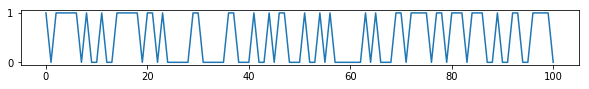

In [17]:
plt.figure(figsize=(10,1))
plt.plot(fake_log)

In [18]:
def plot(binary_array_1d, ax=None):
    return_ax = True
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,0.5))
        return_ax = False
    ax.bar(np.arange(binary_array_1d.size), binary_array_1d, width=1)
    ax.axis('off')
    ax.grid(which='both', axis='x', lw=1, color='k', alpha=0.25)
    if return_ax:
        return ax
    else:
        plt.show()
        return
    
def compare2(array_1, array_2):
    fig, axs = plt.subplots(nrows=2, figsize=(10,1), sharex=True)
    axs[0] = plot(array_1, ax=axs[0])
    axs[1] = plot(array_2, ax=axs[1])
    return

def compare(*args):
    fig, axs = plt.subplots(nrows=len(args), figsize=(10,1), sharex=True)
    for ax, arr in zip(axs, args):
        ax = plot(arr, ax=ax)
    return

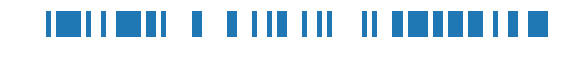

In [19]:
plot(fake_log)

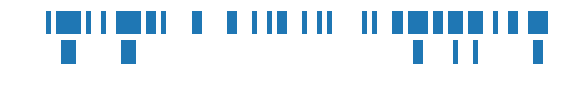

In [20]:
eros = bm.binary_erosion(fake_log, structure=[1,1,1])
compare(fake_log, eros)

In [21]:
def binary_dilation(arr, structure):
    """
    Seems to work the same as scipy for all structure elements.
    """
    L = len(structure)
    if L == 1:
        return arr
    out = (np.convolve(arr, structure, mode='full') > 0).astype(int)
    start = L // 2
    
    # Why is this so complicated??
    if L % 2:  # if L is odd...
        end =   - (L // 2) if L > 3 else -1
    else:
        end = 1 - (L // 2) if L > 3 else None

    return out[start:end]

def binary_erosion(arr, structure):
    """
    Seems to work the same as scipy for all structure elements.
    """
    S = sum(structure)
    return (np.convolve(arr, structure, mode='same') >= S).astype(int)

def binary_opening(arr, structure):
    return binary_dilation(binary_erosion(arr, structure), structure)

def binary_closing(arr, structure):
    return binary_erosion(binary_dilation(arr, structure), structure)

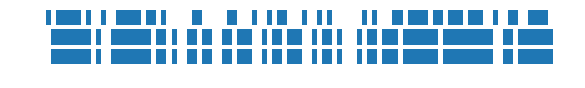

In [22]:
L = 11
dila = bm.binary_dilation(fake_log, structure=[0,1,0,0,1])
dila2 = binary_dilation(fake_log, structure=[0,1,0,0,1])
compare(fake_log, dila, dila2)

In [23]:
len(dila), len(dila2)

(101, 101)

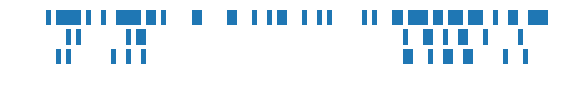

In [24]:
eros = bm.binary_erosion(fake_log, structure=[1,1,0,0,1])
eros2 = binary_erosion(fake_log, structure=[1,1,0,0,1])
compare(fake_log, eros, eros2)

In [25]:
len(eros), len(eros2)

(101, 101)

In [26]:
from tqdm import tqdm

for _ in tqdm(range(1000)):
    
    arr = np.random.randint(0, 2, size=1000)
    se = np.ones(np.random.randint(1, 31))
    
    dila = bm.binary_dilation(arr, structure=[1,0,0,1,1,0,1])
    dila2 = binary_dilation(arr, structure=[1,0,0,1,1,0,1])
    if np.any(dila - dila2):
        print("Dilation failed")
        break

    eros = bm.binary_erosion(arr, structure=[1,0,0,1,1,0,1])
    eros2 = binary_erosion(arr, structure=[1,0,0,1,1,0,1])
    if np.any(eros - eros2):
        print("Erosion failed")
        break
        
    opng = bm.binary_opening(arr, structure=[1,0,0,1,1,0,1])
    opng2 = binary_opening(arr, structure=[1,0,0,1,1,0,1])
    if np.any(opng - opng2):
        print("Opening failed")
        break

    clsg = bm.binary_closing(arr, structure=[1,0,0,1,1,0,1])
    clsg2 = binary_closing(arr, structure=[1,0,0,1,1,0,1])
    if np.any(clsg - clsg2):
        print("Opening failed")
        break
        

  0%|          | 0/1000 [00:00<?, ?it/s]

Erosion failed


## Some statistics

We can get the unique components and their thicknesses:

In [27]:
s.unique

[(Component({'pay': True}), 25.5), (Component({'pay': False}), 25.0)]

We can get at the thickest (and thinnest, with `.thinnest()`) intervals:

In [28]:
s.thickest()

Interval({'top': Position({'middle': 128.5, 'units': 'm'}), 'base': Position({'middle': 131.5, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'pay': True})]})

These functions optionally take an integer argument `n` specifying how many of the thickest or thinnest intervals you want to see. If `n` is greater than 1, a `Striplog` object is returned so you can see the positions of those items:

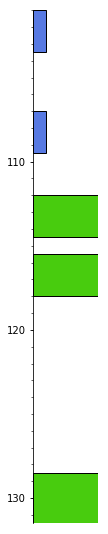

In [29]:
s.thickest(5).plot(legend=legend, lw=1, aspect=5)

## Bar plots and histograms

We can make a bar plot of the layers:

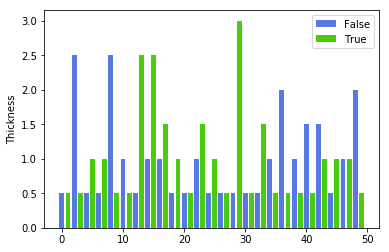

In [30]:
s.bar(legend=legend)

More interesting is to sort the thicknesses:

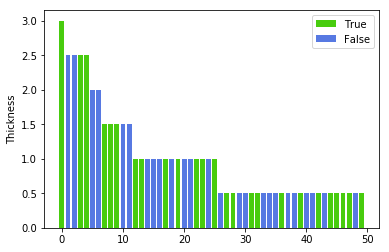

In [31]:
s.bar(legend=legend, sort=True)

Finally, we can make a thickness histogram of the various types of `component` present in the log.

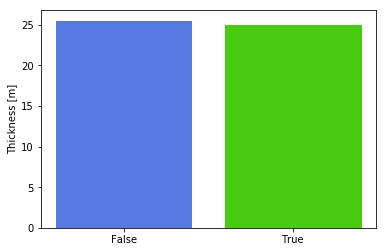

In [32]:
n, ents, ax = s.hist(legend=legend)

In [33]:
s

Striplog(50 Intervals, start=100.0, stop=150.5)

In [46]:
legend

Legend(Decor({'_colour': '#48cc0e', 'hatch': None, 'width': 1.0, 'component': Component({'pay': True})})
Decor({'_colour': '#5779e2', 'hatch': None, 'width': 0.2, 'component': Component({'pay': False})}))

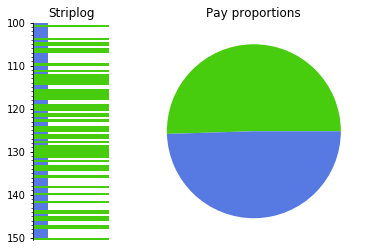

In [60]:
data = [c[1] for c in s.unique]
colors = [c['_colour'] for c in legend.table]

fig, axs = plt.subplots(ncols=2,
                        gridspec_kw={'width_ratios': [1, 3]})

axs[0] = s.plot(ax=axs[0], legend=legend)
axs[0].set_title("Striplog")

axs[1].pie(data, colors=colors)
axs[1].set_title("Pay proportions")

plt.show()

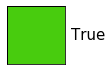

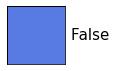

In [62]:
legend.plot()

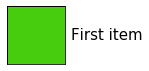

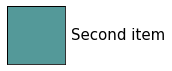

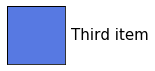

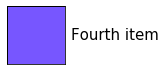

In [77]:
legend_csv = """colour,hatch,width,component attribute
#48cc0e,None,1,First item
#549999,None,1,Second item
#5779e2,None,0.2,Third item
#7756ff,None,0.2,Fourth item
"""

legend = Legend.from_csv(text=legend_csv)

legend.plot()

In [4]:
import flask
import numpy as np

np.array([0]).tolist()

[0]

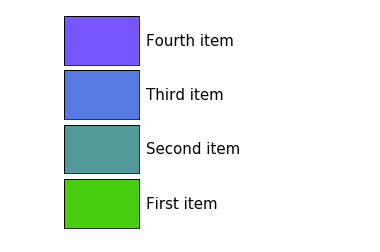

In [101]:
fig, ax = plt.subplots()

height = width = (0.9 / len(legend))
h_incr = 1 / len(legend)
left_pos = 0.1
bot_pos = 0.0
for decor in legend:
    cax = add_subplot_axes(ax, [left_pos, bot_pos, width, height])
    cax = decor.plot(ax=cax)
    bot_pos += h_incr
ax.axis('off')
plt.show()

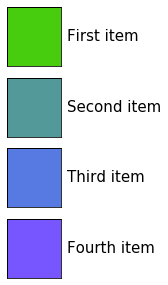

In [80]:
fig, axes = plt.subplots(nrows=len(legend))
fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.2+0.5*(1/len(legend)))
for ax, decor in zip(axes, legend):
    ax = decor.plot(ax=ax)

In [81]:
def add_subplot_axes(ax, rect, axisbg='w'):
    """
    Facilitates the addition of a small subplot within another plot.
    From: http://stackoverflow.com/questions/17458580/
    embedding-small-plots-inside-subplots-in-matplotlib
    License: CC-BY-SA
    Args:
        ax (axis): A matplotlib axis.
        rect (list): A rect specifying [left pos, bot pos, width, height]
    Returns:
        axis: The sub-axis in the specified position.
    """
    def axis_to_fig(axis):
        fig = axis.figure

        def transform(coord):
            a = axis.transAxes.transform(coord)
            return fig.transFigure.inverted().transform(a)

        return transform

    fig = plt.gcf()
    left, bottom, width, height = rect
    trans = axis_to_fig(ax)
    x1, y1 = trans((left, bottom))
    x2, y2 = trans((left + width, bottom + height))
    subax = fig.add_axes([x1, y1, x2 - x1, y2 - y1])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2] ** 0.5
    y_labelsize *= rect[3] ** 0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax


In [13]:
ls ../data

ls: cannot access '../data': No such file or directory


In [14]:
ls 

Basic_objects.ipynb               P-129_striplog_from_image.las
_Cuttings.xlsx                    P-63_cuttings.csv
Display_objects.ipynb             Striplog_and_curves.ipynb
lexicon.json                      Striplog_basics.ipynb
Markov_chains.ipynb               Striplog_expert.ipynb
merging.png                       Striplog_merge.ipynb
merging.svg                       Striplog_with_a_binary_flag.ipynb
M-MG-70_14.3_135.9.png            Striplog_with_datetime.ipynb
Normal_distribution.png           test.pdf
og815.csv                         test.png
P-129_280_1935.png                test.svg
P-129_out.LAS*                    well_for_petrel.csv
P-129_striplog_from_cuttings.las  z_Lithology_legend_gapless2.png


In [15]:
import welly
w = welly.Well.from_las("P-129_out.LAS")

Found nonstandard LAS section: ~Parameter


In [16]:
dir(w)

['__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_plot_depth_track',
 '_repr_html_',
 'add_curves_from_las',
 'add_curves_from_lasio',
 'alias_has_multiple',
 'count_curves',
 'data',
 'data_as_matrix',
 'df',
 'fname',
 'from_las',
 'from_lasio',
 'get_curve',
 'get_mnemonic',
 'get_mnemonics_from_regex',
 'header',
 'is_complete',
 'las',
 'location',
 'make_synthetic',
 'plot',
 'qc_curve_group',
 'qc_data',
 'qc_table_html',
 'survey_basis',
 'to_canstrat',
 'to_las',
 'to_lasio',
 'unify_basis',
 'uwi']

In [17]:
w.fname

'P-129_out.LAS'